# Experiments

- **author:** JB Cabral (<jbc.develop@gmail.com>)

In [2]:
% matplotlib inline

import os
import sys
import tempfile

sys.path.append("..")

import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

import sklearn
from sklearn import feature_selection as fs
from sklearn import preprocessing as prp
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from IPython import display as d



pd.options.mode.chained_assignment = None 



## 1. Load Data

In [3]:
obs = pd.read_pickle("../data/rrb278_obs.pkl")

In [6]:
classes = set(df.ogle3_type)
sclasses_names = set(c.split("-", 1)[0] for c in classes)
classes = dict(zip(sorted(classes), range(len(classes))))
sclasses = dict(zip(sorted(sclasses_names), range(len(sclasses_names))))

df["cls"] = df.ogle3_type.apply(classes.get)
df["scls"] = df.ogle3_type.apply(lambda v: sclasses.get(v.split("-", 1)[0]))
    
d.display(d.Markdown("### Classes"))
d.display(classes)

d.display(d.Markdown("### Simplified Classes"))
d.display(sclasses)

### Classes

{'': 0,
 'Cep-1': 1,
 'Cep-F': 2,
 'LPV-Mira': 3,
 'LPV-OSARG': 4,
 'LPV-SRV': 5,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 9,
 'T2Cep-RVTau': 10,
 'T2Cep-WVir': 11}

### Simplified Classes

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

In [8]:
def get_o3id(o3id):
    return ogle3[ogle3["# ID"] == o3id].P_1.values[0]
    
rr = df[df.scls == 3]
rr["ogle3_id"] = rr.id.apply(lambda cid: tile[tile.id == cid].ogle3_id.values[0])
rr["ogle3_period"] = rr.ogle3_id.apply(get_o3id)
rr["fvo3_p"] = np.abs(rr.PeriodLS - rr.ogle3_period)

In [9]:
rr = rr[["id", "cls", "scls", "ogle3_id", "PeriodLS", "ogle3_period"]]

In [10]:
from FATS.FeatureFunctionLib import PeriodLS

fats_period = PeriodLS()

def calculate_p_FATS(src):
    lc = obs[obs.bm_src_id == src.id]
    lc = lc.sort_values("pwp_stack_src_hjd")
    hjd, mag, err = (lc.pwp_stack_src_hjd.values, 
                     lc.pwp_stack_src_mag3.values, 
                     lc.pwp_stack_src_mag_err3.values)
    
    return fats_period.fit([mag, hjd])

if "FATS_P" not in rr.columns:
    rr["FATS_p"] = rr.apply(calculate_p_FATS, axis=1)

/home/jbcabral/projects/paper_b278/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [11]:
import feets


def calculate_p_feets(src):
    space = feets.FeatureSpace(only=["PeriodLS"])
    lc = obs[obs.bm_src_id == src.id]
    lc = lc.sort_values("pwp_stack_src_hjd")
    hjd, mag, err = (lc.pwp_stack_src_hjd.values, 
                     lc.pwp_stack_src_mag3.values, 
                     lc.pwp_stack_src_mag_err3.values)
    
    
    return space.extract_one([mag, hjd])[1][0]


rr["feets_p"] = rr.apply(calculate_p_feets, axis=1)

In [12]:
rr.describe()

,id,cls,scls,PeriodLS,ogle3_period,FATS_p,feets_p
count,4.240000e+02,424.000000,424.0,424.000000,424.000000,424.000000,424.000000
mean,3.278000e+13,6.330189,3.0,102.247228,0.478740,1.013958,102.247228
std,2.710964e+05,0.485666,0.0,971.407077,0.139233,4.042695,971.407077
min,3.278000e+13,6.000000,3.0,3.048541,0.206849,0.204042,3.048541
25%,3.278000e+13,6.000000,3.0,9.196291,0.345851,0.472139,9.196291
50%,3.278000e+13,6.000000,3.0,14.299811,0.495343,0.560913,14.299811
75%,3.278000e+13,7.000000,3.0,32.079731,0.577338,0.738655,32.079731
max,3.278000e+13,8.000000,3.0,19647.845189,0.919409,80.195270,19647.845189


In [13]:
resume = rr[["ogle3_period", "FATS_p", "feets_p"]]
resume = pd.DataFrame({
    "ogle3_p": rr.ogle3_period / rr.ogle3_period.sum(),
    "FATS_p": rr.FATS_p / rr.FATS_p.sum(),
    "feets_p": rr.feets_p / rr.feets_p.sum()
})
resume.describe()

,FATS_p,feets_p,ogle3_p
count,424.000000,424.000000,424.000000
mean,0.002358,0.002358,0.002358
std,0.009403,0.022407,0.000686
min,0.000475,0.000070,0.001019
25%,0.001098,0.000212,0.001704
50%,0.001305,0.000330,0.002440
75%,0.001718,0.000740,0.002844
max,0.186536,0.453208,0.004529


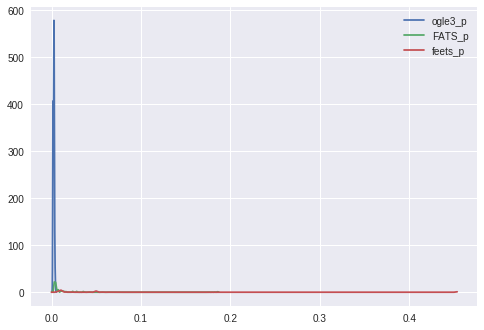

In [14]:
ax = sns.kdeplot(resume.ogle3_p)
sns.kdeplot(resume.FATS_p)
sns.kdeplot(resume.feets_p)

In [16]:
space = feets.FeatureSpace(only=["PeriodLS"])

In [24]:
feets.extractor_of("PeriodLS").__module__

'feets.extractors.ext_lomb_scargle'

In [26]:
import feets.extractors.ext_lomb_scargle as ls

In [71]:
from astropy.stats import LombScargle
sample = df[df.scls == 3].sample().iloc[0]
print sample.cls
lc = obs[obs.bm_src_id == sample.id]
lc = lc.sort_values("pwp_stack_src_hjd")
hjd, mag, err = (lc.pwp_stack_src_hjd.values, 
                 lc.pwp_stack_src_mag3.values, 
                 lc.pwp_stack_src_mag_err3.values)

6


In [72]:
frequency, power = LombScargle(hjd, mag, err).autopower()

In [73]:
kwargs = dict(minimum_frequency=0.2, maximum_frequency=1.4)

frequency, power, fmax = ls.lscargle(hjd, mag, err, autopower_kwds=kwargs)
best_period = 1 / frequency[fmax]
print frequency, power, fmax, best_period

[ 0.2         0.20010179  0.20020358 ...,  1.39982625  1.39992804
  1.40002983] [ 0.04385037  0.04980433  0.04777392 ...,  0.00887699  0.0021427
  0.01285724] 7869 0.998997125055


<Container object of 3 artists>

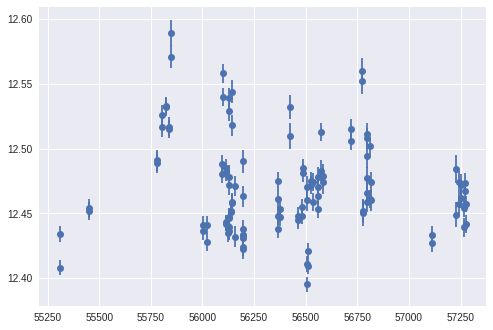

In [74]:
plt.errorbar(hjd, mag, err, fmt='o')

In [75]:
rr[rr.id == sample.id]

,id,cls,scls,ogle3_id,PeriodLS,ogle3_period,FATS_p,feets_p
4223,32780000738339,6,3,OGLE-BLG-RRLYR-12679,7.389186,0.499077,0.499077,7.389186
